# Mamba sampling for a simple linear regression

This notebook is a modification of an example in the documentation of the Mamba package

In [1]:
addprocs(4);
using Compat, Distributions, Mamba

exception on 1: exception on exception on exception on ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
111: : : ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in ope

A simple linear regression model is given in the [Mamba manual](http://mambajl.readthedocs.org/en/latest/) as

In [2]:
model = Model(
  y = Stochastic(1, @modelexpr(μ, σ², MvNormal(μ, √σ²)), false),
  μ = Logical(1, @modelexpr(xmat, β, xmat * β), false),
  β = Stochastic(1,:(MvNormal(fill(sqrt(1000),2)))),
  σ² = Stochastic(:(InverseGamma(0.001, 0.001)))
);

In this formulation the sampling of `σ²` is on the variance scale.

To use a Hybrid No-U-Turn and Slice sampling scheme we would set

In [3]:
scheme1 = [NUTS([:β]), Slice([:σ²], [3.0])];

A strict No-U-Turn sampling scheme would be

In [4]:
scheme2 = [NUTS([:β, :σ²])];

Alternatively, one could set user-defined samplers (because the priors are conjugate priors).

In [5]:
Gibbs_β = Sampler([:β],
  @modelexpr(β, σ², xmat, y,
    begin
      β_mean = mean(β.distr)
      β_invcov = invcov(β.distr)
      Σ = inv(xmat'xmat / σ² + β_invcov)
      μ = Σ * (xmat'y / σ² + β_invcov * β_mean)
      rand(MvNormal(μ,Σ))
    end
  )
);

In [6]:
Gibbs_σ² = Sampler([:σ²],
  @modelexpr(β, σ², xmat, y,
    begin
      a = length(y) / 2.0 + shape(σ².distr)
      b = sum((y - xmat * β).^2) / 2.0 + scale(σ².distr)
      rand(InverseGamma(a, b))
    end
  )
);

Next we formulate the data

In [7]:
line = @compat Dict{Symbol,Any}(
  :x => [1, 2, 3, 4, 5],
  :y => [1, 3, 3, 3, 5]
);

In [8]:
line[:xmat] = hcat(ones(5),line[:x]);

and set the random number seed for reproducibility

In [9]:
srand(1234321)

The initial values, except for the response, `y`, are chosen at random.  There will be 4 chains, each running on a separate process.

In [10]:
inits = [@compat Dict{Symbol,Any}(
    :y => line[:y],
    :β => rand(Normal(0, 1), 2),
    :σ² => rand(Gamma(1, 1))) for i in 1:4]  # 4 chains

4-element Array{Dict{Symbol,Any},1}:
 [:β=>[-0.0966725,3.3424],:σ²=>2.4306662694828773,:y=>[1,3,3,3,5]]
 [:β=>[-1.17272,-2.05007],:σ²=>0.1928067815668955,:y=>[1,3,3,3,5]]
 [:β=>[-2.08457,2.85367],:σ²=>0.7336237240449138,:y=>[1,3,3,3,5]] 
 [:β=>[0.30227,-0.823113],:σ²=>2.3617521822377294,:y=>[1,3,3,3,5]]

We establish the samplers as the Gibbs samplers.  That is, they sample from a full conditional distribution.

In [11]:
setsamplers!(model,[Gibbs_β, Gibbs_σ²]);

In [12]:
draw(model)   # need to set this to draw in IJulia

digraph MambaModel {
	"β" [shape="ellipse"];
		"β" -> "μ";
	"σ²" [shape="ellipse"];
		"σ²" -> "y";
	"μ" [shape="diamond", fillcolor="gray85", style="filled"];
		"μ" -> "y";
	"xmat" [shape="box", fillcolor="gray85", style="filled"];
		"xmat" -> "μ";
	"y" [shape="ellipse", fillcolor="gray85", style="filled"];
}


In [13]:
sim3 = mcmc(model, line, inits, 10000, burnin=2500, thin=2, chains=4);

MCMC Simulation of 10000 Iterations x 4 Chains...

	From worker 3:	Chain 2:   0% [0:15:32 of 0:15:33 remaining]
	From worker 3:	Chain 2:  10% [0:00:09 of 0:00:10 remaining]
	From worker 5:	Chain 4:   0% [0:16:23 of 0:16:24 remaining]
	From worker 2:	Chain 1:   0% [0:15:49 of 0:15:50 remaining]
	From worker 3:	Chain 2:  20% [0:00:04 of 0:00:05 remaining]
	From worker 5:	Chain 4:  10% [0:00:10 of 0:00:11 remaining]
	From worker 2:	Chain 1:  10% [0:00:09 of 0:00:11 remaining]
	From worker 5:	Chain 4:  20% [0:00:05 of 0:00:06 remaining]
	From worker 2:	Chain 1:  20% [0:00:04 of 0:00:05 remaining]
	From worker 3:	Chain 2:  30% [0:00:03 of 0:00:04 remaining]
	From worker 3:	Chain 2:  40% [0:00:02 of 0:00:03 remaining]
	From worker 5:	Chain 4:  30% [0:00:03 of 0:00:04 remaining]
	From worker 2:	Chain 1:  30% [0:00:03 of 0:00:04 remaining]
	From worker 4:	Chain 3:   0% [0:16:30 of 0:16:31 remaining]
	From worker 3:	Chain 2:  50% [0:00:01 of 0:00:03 remaining]
	From worker 5:	Chain 4:  40% [0:0

The first time that chains are simulated the various samplers must be compiled.  Once they have been compiled sampling is very fast

In [14]:
@time mcmc(model, line, inits, 10000, burnin=2500, thin=2, chains=4);

MCMC Simulation of 10000 Iterations x 4 Chains...

	From worker 2:	Chain 1:   0% [0:00:00 of 0:00:00 remaining]
	From worker 3:	Chain 2:   0% [0:00:00 of 0:00:00 remaining]
	From worker 4:	Chain 3:   0% [0:00:00 of 0:00:00 remaining]
	From worker 5:	Chain 4:   0% [0:00:00 of 0:00:00 remaining]
	From worker 2:	Chain 1:  10% [0:00:00 of 0:00:00 remaining]
	From worker 3:	Chain 2:  10% [0:00:00 of 0:00:00 remaining]
	From worker 5:	Chain 4:  10% [0:00:00 of 0:00:00 remaining]
	From worker 4:	Chain 3:  10% [0:00:00 of 0:00:00 remaining]
	From worker 2:	Chain 1:  20% [0:00:00 of 0:00:00 remaining]
	From worker 3:	Chain 2:  20% [0:00:00 of 0:00:00 remaining]
	From worker 5:	Chain 4:  20% [0:00:00 of 0:00:00 remaining]
	From worker 4:	Chain 3:  20% [0:00:00 of 0:00:00 remaining]
	From worker 3:	Chain 2:  30% [0:00:00 of 0:00:00 remaining]
	From worker 2:	Chain 1:  30% [0:00:00 of 0:00:00 remaining]
	From worker 5:	Chain 4:  30% [0:00:00 of 0:00:00 remaining]
	From worker 4:	Chain 3:  30% [0:0

In [15]:
gelmandiag(sim3, mpsrf=true,transform=true) 

5x3 Array{Any,2}

:
 ""               "PSRF"      "97.5%"
 "\u3b2[1]"      1.00019     1.00044 
 "\u3b2[2]"      1.00232     1.00266 
 "\u3c3\ub2"     0.999909    0.999979
 "Multivariate"  1.00016   NaN       

In [16]:
gewekediag(sim3)

4x3x4 Array{Any,3}:
[:, :, 1] =
 

""             "Z-score"   "p-value"
 "\u3b2[1]"   -1.71952     0.0855191 
 "\u3b2[2]"    1.60262     0.109018  
 "\u3c3\ub2"  -1.57434     0.115408  

[:, :, 2] =
 ""             "Z-score"   "p-value"
 "\u3b2[1]"    0.0845497   0.932619  
 "\u3b2[2]"    0.31859     0.750037  
 "\u3c3\ub2"  -2.12131     0.0338955 

[:, :, 3] =
 ""             "Z-score"   "p-value"
 "\u3b2[1]"    0.154278    0.877391  
 "\u3b2[2]"   -0.689388    0.490579  
 "\u3c3\ub2"  -0.058924    0.953013  

[:, :, 4] =
 ""             "Z-score"   "p-value"
 "\u3b2[1]"    0.249153    0.803243  
 "\u3b2[2]"   -0.544741    0.585932  
 "\u3c3\ub2"  -1.09793     0.272236  

In [17]:
describe(sim3)

Iterations = 2502:10000
Thinning interval = 2
Chains = 1,2,3,4
Samples per chain = 3750

Empirical Posterior Estimates:
4x6 Array{Any,2}:
 ""            "Mean"     "SD"      "Naive SE"   "MCSE"          "ESS"
 "\u3b2[1]"   0.599724   1.38409   0.011301     0.0109213   15000.0   
 "\u3b2[2]"   0.797948   0.434402  0.00354688   0.00333507  15000.0   
 "\u3c3\ub2"  1.98397   35.978     0.293759     0.30344     14521.4   

Quantiles:
4x6 Array{Any,2}:
 ""             "2.5%"      "25.0%"    "50.0%"   "75.0%"   "97.5%"
 "\u3b2[1]"   -1.91526    -0.0165459  0.591554  1.16746   3.09195 
 "\u3b2[2]"    0.0491071   0.625545   0.802493  0.981095  1.54973 
 "\u3c3\ub2"   0.172267    0.390242   0.672476  1.34103   7.55397 


In [18]:
hpd(sim3)

4x3 Array{Any,2}

:
 ""             "2.5%"     "97.5%"
 "\u3b2[1]"   -1.93159    3.06574 
 "\u3b2[2]"    0.0624259  1.55889 
 "\u3c3\ub2"   0.0798682  4.70237 

In [19]:
p = plot(sim3);

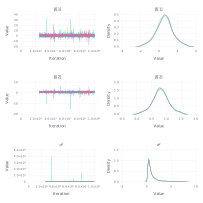

In [20]:
draw(p)

## Alternative formulation

Often in a Bayesian analysis it is preferably to use a canonical parameterization of a distribution.  In the case of a multivariate normal distribution the canonical parameterization is based on the _precision matrix_, Σ⁻¹, instead of the covariance matrix, Σ.  The prior distribuiton for β, which we have written as

In [21]:
β₁ = MvNormal(2,sqrt(1000.))

ZeroMeanIsoNormal(
dim: 2
μ: [0.0,0.0]
Σ: 2x2 Array{Float64,2}:
 1000.0     0.0
    0.0  1000.0
)


is a zero-mean bivariate normal distribution with the covariance matrix shown.  In the canonical form this is

In [22]:
β₂ = MvNormalCanon(2,0.001)

ZeroMeanIsoNormalCanon(
μ: ZeroVector{Float64}(2)
h: ZeroVector{Float64}(2)
J: ScalMat(2,0.001,1000.0)
)


These are the same distribuion.  Both have zero mean and

In [23]:
cov(β₁)

2x2 Array{Float64,2}:
 1000.0     0.0
    0.0  1000.0

is the same as

In [24]:
cov(β₂)

2x2 Array{Float64,2}:
 1000.0     0.0
    0.0  1000.0

In [30]:
invcov(β₂)

2x2 Array{Float64,2}:
 0.001  0.0  
 0.0    0.001

In [31]:
names(β₂)

3-element Array{Symbol,1}:
 :μ
 :h
 :J

In [32]:
β₂.J

ScalMat(2,0.001,1000.0)

The likelihood contribution from the model is also more easily written in the canonical form.  Recall that the covariance matrix of the coefficient estimates, β, is σ²(X'X)⁻¹, implying that the precision matrix is (X'X)/σ².  Furthermore, the _potential vector_  of this distribution is X'y/σ².  Both can be precalculated up to the value of σ².

In [45]:
using PDMats
line[:XtX] = PDMat(line[:xmat]'line[:xmat])
line[:Xty] = line[:xmat]'line[:y];

This allows us to write the `Gibbs`_β sampler as

In [75]:
Gibbs_β = Sampler([:β],
@modelexpr(β, σ², XtX, Xty, rand(MvNormalCanon(Xty/σ²,XtX*inv(σ².value) + invcov(β.distr)))));

The `Gibbs_`σ² sampler can also be simplified if we take into account the the `abs2` function in Julia returns the square of a number and `sumabs2` returns the sum of squares of a vector.

In [34]:
Gibbs_σ² = Sampler([:σ²],
  @modelexpr(β, σ², xmat, y, rand(InverseGamma(length(y)>>1 + shape(σ².distr),
    sumabs2(y-μ)/2.0 + scale(σ².distr)))));

In [76]:
modl2 = Model(
  y = Stochastic(1, @modelexpr(μ, σ², MvNormal(μ, √σ²)), false),
  μ = Logical(1, @modelexpr(xmat, β, xmat * β), false),
  r = Logical(1, @modelexpr(y, μ, y - μ), false),
  β = Stochastic(1,:(MvNormalCanon(2,0.001))),
  σ² = Stochastic(:(InverseGamma(0.001, 0.001)))
);

In [77]:
setsamplers!(modl2,[Gibbs_β,Gibbs_σ²]);
showall(modl2)

Object of type "Model"
-------------------------------------------------------------------------------
β:
A monitored node of type "Stochastic{Array{Float64,1}}"
[]

Distribution:
NullDistribution()
Function:
AST(:($(Expr(:lambda, {:(model::(top(getfield))(Mamba,:Model))}, {{},{{:model,:Any,18}},{}}, :(begin 
        model = (top(typeassert))(model,(top(getfield))(Mamba,:Model))
        return MvNormalCanon(2,0.001)
    end)))))

Source Nodes:
[]

Target Nodes:
[:μ,:y,:r]
-------------------------------------------------------------------------------
r:
An unmonitored node of type "Logical{Array{Float64,1}}"
[]
Function:
AST(:($(Expr(:lambda, {:(model::(top(getfield))(Mamba,:Model))}, {{:y,:μ},{{:model,:Any,18},{:y,:Any,18},{:μ,:Any,18}},{}}, :(begin 
        model = (top(typeassert))(model,(top(getfield))(Mamba,:Model))
        y = getindex(model,:y)
        μ = getindex(model,:μ)
        return y - μ
    end)))))

Source Nodes:
[:y,:μ]

Target Nodes:
[]
------------------------------

In [43]:
sim4 = mcmc(modl2, line, inits, 10000, burnin=2500, thin=2, chains=4);

MCMC Simulation of 10000 Iterations x 4 Chains...



exception on 2: ERROR: key not found: :XtX
 in getindex at /home/juser/.julia/v0.3/Mamba/src/model/core.jl:32
 in anonymous at no file
 in simulate! at /home/juser/.julia/v0.3/Mamba/src/model/simulation.jl:115
 in simulate! at /home/juser/.julia/v0.3/Mamba/src/model/simulation.jl:107
 in mcmc_worker! at /home/juser/.julia/v0.3/Mamba/src/model/mcmc.jl:71
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
exception on 3: ERROR: key not found: :XtX
 in getindex at /home/juser/.julia/v0.3/Mamba/src/model/core.jl:32
 in anonymous at no file
 in simulate! at /home/juser/.julia/v0.3/Mamba/src/model/simulation.jl:115
 in simulate! at /home/juser/.julia/v0.3/Mamba/src/model/simulation.jl:107
 in mcmc_worker! at /home/juser/.julia/v0.3/Mamba/src/model/mcmc.jl:71
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
exception on 4: ERROR: key not found: :XtX
 in getindex at /home/juser/.julia/v0.3/Mamba/src/model/c

LoadError: type KeyError has no field model
while loading In[43], in expression starting on line 1

In [80]:
setinputs!(modl2,line)

Object of type "Model"
-------------------------------------------------------------------------------
β:
A monitored node of type "Stochastic{Array{Float64,1}}"
[]
-------------------------------------------------------------------------------
xmat:
5x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0
-------------------------------------------------------------------------------
r:
An unmonitored node of type "Logical{Array{Float64,1}}"
[]
-------------------------------------------------------------------------------
σ²:
A monitored node of type "Stochastic{Float64}"
NaN
-------------------------------------------------------------------------------
μ:
An unmonitored node of type "Logical{Array{Float64,1}}"
[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "Stochastic{Array{Float64,1}}"
[]


In [81]:
setinits!(modl2,inits[1])

Object of type "Model"
-------------------------------------------------------------------------------
β:
A monitored node of type "Stochastic{Array{Float64,1}}"
[-0.0966725,3.3424]
-------------------------------------------------------------------------------
xmat:
5x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0
-------------------------------------------------------------------------------
r:
An unmonitored node of type "Logical{Array{Float64,1}}"
[-2.24573,-3.58813,-6.93053,-10.2729,-11.6153]
-------------------------------------------------------------------------------
σ²:
A monitored node of type "Stochastic{Float64}"
2.4306662694828773
-------------------------------------------------------------------------------
μ:
An unmonitored node of type "Logical{Array{Float64,1}}"
[3.24573,6.58813,9.93053,13.2729,16.6153]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "Stochastic{Array{Float64,1}}"
[

In [56]:
typeof(modl2.nodes)

Dict{Symbol,Any} (constructor with 3 methods)

In [57]:
typeof(modl2.nodes[:xmat])

Array{Float64,2}

In [82]:
modl2.nodes[:XtX] = line[:XtX]

PDMat(2,2x2 Array{Float64,2}:
  5.0  15.0
 15.0  55.0,Cholesky{Float64} with factor:
2x2 Triangular{Float64,Array{Float64,2},:U,false}:
 2.23607  6.7082 
 0.0      3.16228)

In [83]:
modl2.nodes[:Xty] = line[:Xty]

2-element Array{Float64,1}:
 15.0
 53.0

In [61]:
names(modl2)

9-element Array{Symbol,1}:
 :nodes     
 :dependents
 :samplers  
 :states    
 :iter      
 :burnin    
 :chain     
 :hasinputs 
 :hasinits  

In [62]:
modl2.hasinputs

true

In [63]:
modl2.hasinits

false

In [64]:
modl2.iter

0

In [65]:
modl2.iter = 10000; modl2.burnin = 2500;

In [67]:
sim4 = mcmc(modl2, thin=2)

LoadError: `mcmc` has no method matching mcmc(::Model)
while loading In[67], in expression starting on line 1

In [68]:
methods(mcmc)

# 2 methods for generic function "mcmc":
mcmc(c::Chains,iters::Integer) at /home/juser/.julia/v0.3/Mamba/src/model/mcmc.jl:6
mcmc(m::Model,inputs::Dict{Symbol,V},inits::Array{Dict{Symbol,Any},1},iters::Integer) at /home/juser/.julia/v0.3/Mamba/src/model/mcmc.jl:29

In [85]:
simulate!(modl2,1)

Object of type "Model"
-------------------------------------------------------------------------------
β:
A monitored node of type "Stochastic{Array{Float64,1}}"
[1.20788,0.703702]
-------------------------------------------------------------------------------
XtX:
PDMat(2,2x2 Array{Float64,2}:
  5.0  15.0
 15.0  55.0,Cholesky{Float64} with factor:
2x2 Triangular{Float64,Array{Float64,2},:U,false}:
 2.23607  6.7082 
 0.0      3.16228)
-------------------------------------------------------------------------------
xmat:
5x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0
-------------------------------------------------------------------------------
Xty:
[15.0,53.0]
-------------------------------------------------------------------------------
r:
An unmonitored node of type "Logical{Array{Float64,1}}"
[-0.911586,0.384712,-0.31899,-1.02269,0.273605]
-------------------------------------------------------------------------------
σ²:
A monitored node of type "Stochasti

In [84]:
modl2.nodes

Dict{Symbol,Any} with 8 entries:
  :β…     => A monitored node of type "Stochastic{Array{Float64,1}}"…
  :XtX  => PDMat(2,[5.0 15.0…
  :xmat => [1.0 1.0…
  :Xty  => [15.0,53.0]
  :r    => An unmonitored node of type "Logical{Array{Float64,1}}"…
  :σ²…     => A monitored node of type "Stochastic{Float64}"…
  :μ…     => An unmonitored node of type "Logical{Array{Float64,1}}"…
  :y    => An unmonitored node of type "Stochastic{Array{Float64,1}}"…